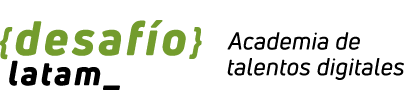

#<center><font color = 'green'>Solución Prueba - Predicción del precio de vuelos</font></center>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score, mean_absolute_error

import warnings

warnings.filterwarnings('ignore')

## 1. Lectura de datos

In [ ]:
df_business = pd.read_csv('business.csv')
df_economy = pd.read_csv('economy.csv')

In [ ]:
print(f'Dimensiones del dataset business: {df_business.shape}')
print(f'Dimensiones del dataset business: {df_economy.shape}')

Dimensiones del dataset business: (93487, 11)
Dimensiones del dataset business: (206774, 11)


In [ ]:
df_economy.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5.953
1,11-02-2022,SpiceJet,SG,8157,6:20,Delhi,02h 20m,non-stop,8:40,Mumbai,5.953
2,11-02-2022,AirAsia,I5,764,4:25,Delhi,02h 10m,non-stop,6:35,Mumbai,5.956
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5.955
4,11-02-2022,Vistara,UK,963,8:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5.955


In [ ]:
df_business.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,25.612
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,25.612
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,42.220
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,44.450
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,46.690


### Punto
Se pueden unir los dataset y generar una nueva variable de tipo_boleto en casi cualquier etapa, por facilidad la pauta lo hará al inicio antes de comenzar con la calidad de datos misma, pero la generación de la variable se evalua en la parte de creación de variables como imprescindible.

In [ ]:
df_business['tipo_boleto'] = 'business'
df_economy['tipo_boleto'] = 'economy'

df = pd.concat([df_business, df_economy]).reset_index(drop=True)

## 2. Data Understanding: Calidad de datos

In [ ]:
def data_quality_report(data):
    # Resumen de estadísticas descriptivas
    summary_stats = data.describe(include='all').T
    # Tipo de dato
    tipo_dato = data.dtypes
    tipo_dato = (tipo_dato
                .reset_index()
                .set_index('index')
                .rename(columns={0: 'tipo'})
                )
    # Datos faltantes
    missing_data = data.isnull().sum()
    missing_data = (missing_data
                    .reset_index()
                    .set_index('index')
                    .rename(columns={0: 'null'})
                    )
    missing_data_mean = data.isnull().mean()
    missing_data_mean = (missing_data_mean
                        .reset_index()
                        .set_index('index')
                        .rename(columns={0: 'null_perc'})
                        )
    # Concatenar los resultados
    data_quality_report = pd.concat([tipo_dato, summary_stats, missing_data, missing_data_mean], axis=1)

    return data_quality_report

In [ ]:
quality_report = data_quality_report(df)
quality_report

,tipo,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null,null_perc
date,object,300261,49,07-03-2022,6633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
airline,object,300261,8,Vistara,127859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
ch_code,object,300261,8,UK,127859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
num_code,int64,300261.0,NaN,NaN,NaN,1417.771709,1974.514439,101.0,637.0,818.0,927.0,9991.0,0,0.0
dep_time,object,300261,251,7:00,8760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
from,object,300261,6,Delhi,61345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
time_taken,object,300261,483,02h 10m,4242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
stop,object,300261,40,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,243603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
arr_time,object,300261,266,19:55,9194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
to,object,300261,6,Mumbai,59109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


Posibles conclusiones:
- No se observan valores nulos en el dataset
- Observar que Date esta en tipo object y no tipo date
- Hay 8 aerolineas (Hay que observar como se distribuyen)
- Hay 6 paises posibles de partida y 6 llegadas posibles
- La variable time_taken es una variable objet y se debe extraer el tiempo como variable numerica
- price es nuestra variable objetivo
- Tenemos el tiempo de salida y tiempo de llegada como object y hay que transformarlo en numeros
- Por definir que hacer con ch_code y num_code.

## **Transformaciones**



In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.date
df['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour
df['arr_time'] = pd.to_datetime(df['arr_time']).dt.hour
df['horas'] = pd.to_numeric(df['time_taken'].str.split(' ').str[0].str.replace('h', ''))
df['mins'] = pd.to_numeric(df['time_taken'].str.split(' ').str[1].str.replace('m', '')).fillna(0)
df['minutes_taken'] = (df['horas'] * 60 + df['mins']).astype('int')
df['stop'] = df['stop'].str.extract('(\d)').fillna(0)
#df['price'] = df['price'].str.replace(',', '').astype('float')
df['price'] = df['price'].astype('str').str.replace(',', '').astype('float')

df = df.drop(['ch_code', 'num_code', 'time_taken', 'horas', 'mins'], axis=1)
df.head()

,date,airline,dep_time,from,stop,arr_time,to,price,tipo_boleto,minutes_taken
0,2022-02-11,Air India,18,Delhi,0,20,Mumbai,25.612,business,120
1,2022-02-11,Air India,19,Delhi,0,21,Mumbai,25.612,business,135
2,2022-02-11,Air India,20,Delhi,1,20,Mumbai,42.220,business,1485
3,2022-02-11,Air India,21,Delhi,1,23,Mumbai,44.450,business,1590
4,2022-02-11,Air India,17,Delhi,1,23,Mumbai,46.690,business,400


## 3. Analisis Exploratorio

### Analisis univariado

In [ ]:
def plot_distributions(data, columns_review=None):
    plt.rcParams.update({'font.size': 25})
    if columns_review:
        columns_distributions = columns_review
    else:
        columns_distributions = data.columns

    plt.figure(figsize=(30, 30))
    number_rows = len(columns_distributions)//2 + len(columns_distributions)%2
    for n, i in enumerate(columns_distributions):
        plt.subplot(5, 2, n + 1)
        if data.dtypes[i]=='O':
            sns.countplot(y= data[i], order=data[i].value_counts().iloc[:7].index)
            plt.title('Frecuencias para {}'.format(i))
        else:
            sns.distplot(data[i])
            plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

2022-02-11 ---- 2022-03-31


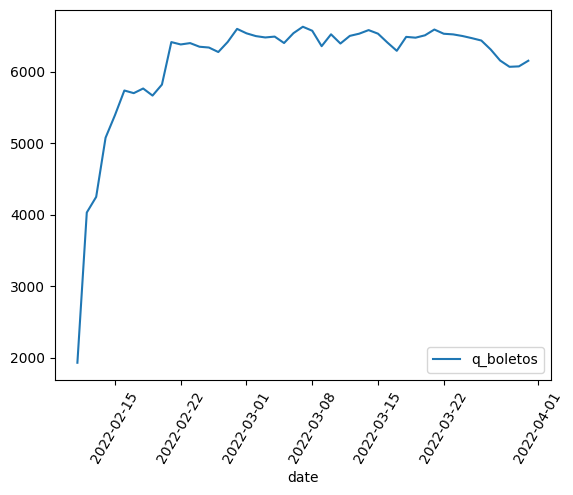

In [ ]:
## EXPLORACION DE LAS FECHAS
print(df.date.min(), '----', df.date.max())

plt.rcParams.update({'font.size': 10})
df.groupby('date').agg(q_boletos=('date', 'count')).plot()
plt.xticks(rotation=60)
plt.show()

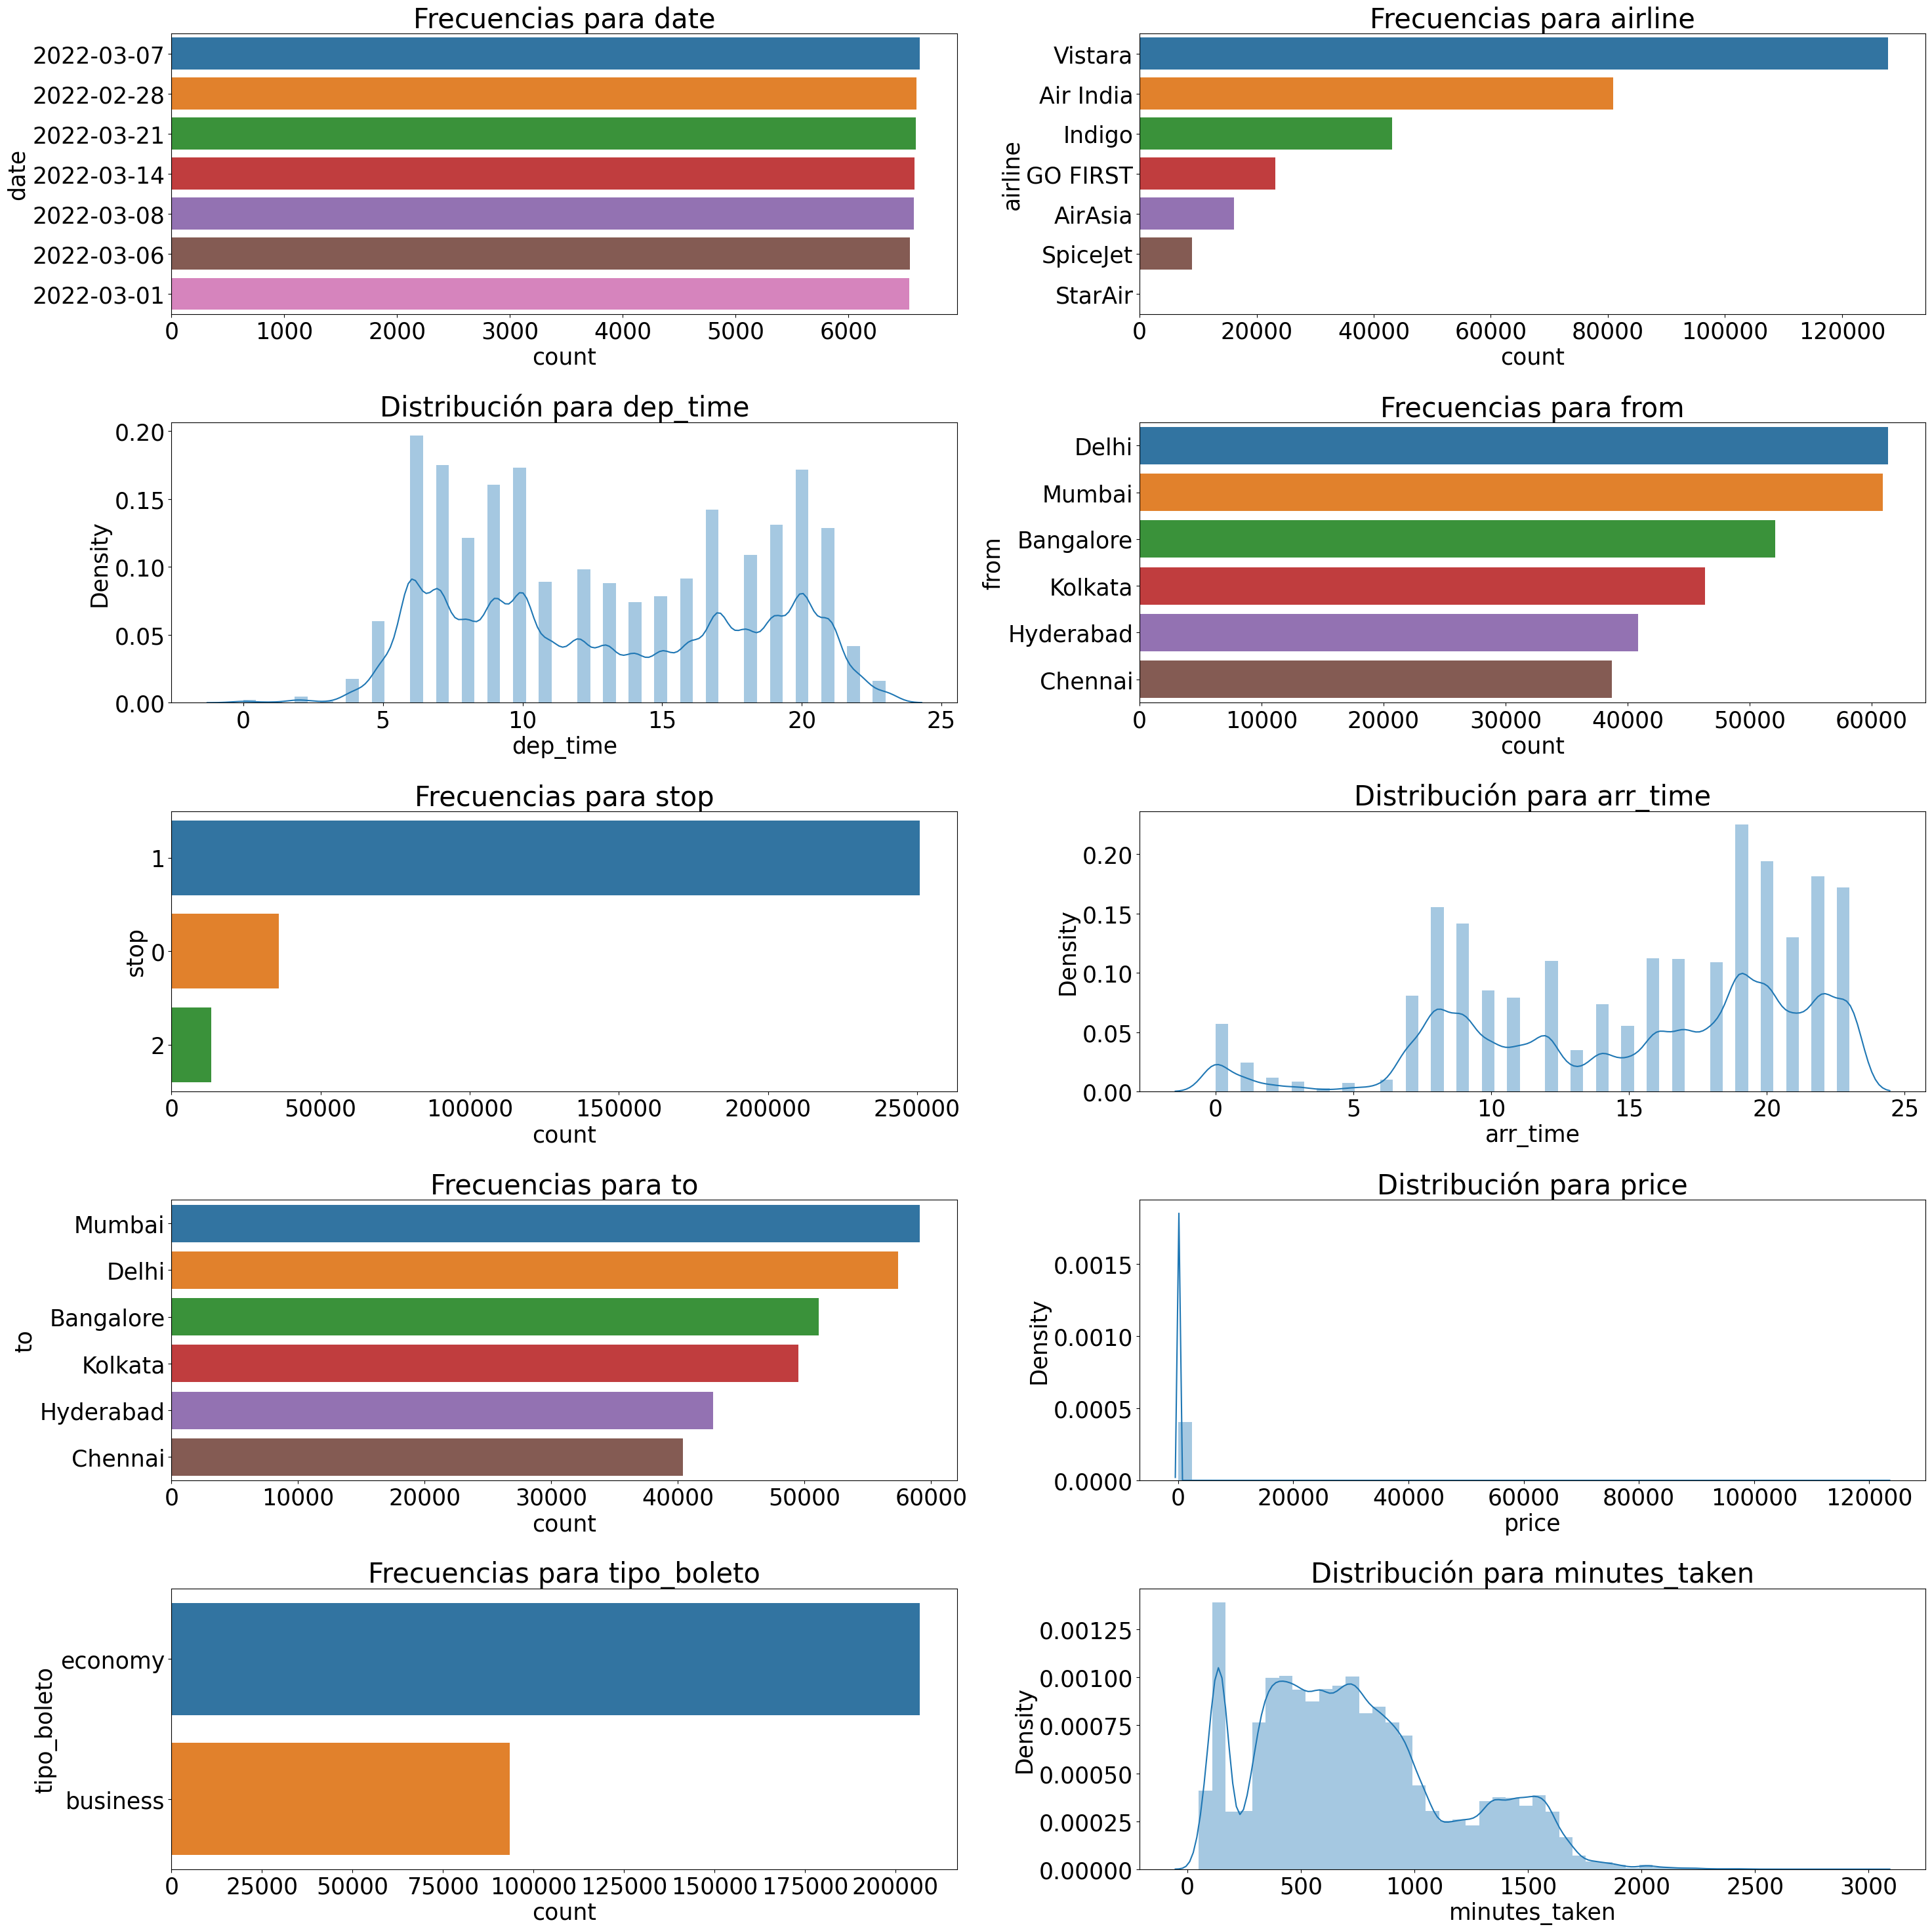

In [ ]:
plot_distributions(df, columns_review=None)

**Comentarios**

- Se observa que la variable objetivo tiene una distribucion bi-normal, donde se observan 2 comportamientos
- En minutes taken se observan 3 comportamientos
- La cantidad de boletos en los dias estudiados es mas o menos similar (Son muy pocos días para generar variables de tiempo como estacionalidad en los meses)
- La mayoría de los vuelos tienen 1 escala
- Etc (es posible que los estudiantes realicen otras observaciones)

### Grafico Bivariado (Respecto de la variable Price)

In [ ]:
def plot_relation(data, var_obj, columns_review=None):
    plt.rcParams.update({'font.size': 25})
    if columns_review:
        columns_distributions = columns_review
    else:
        columns_distributions = data.columns

    plt.figure(figsize=(15, 40))
    number_rows = len(columns_distributions)//2 + len(columns_distributions)%2
    for n, i in enumerate(columns_distributions):
        plt.subplot(len(columns_distributions), 1, n + 1)
        if data.dtypes[i]=='O':
            sns.boxplot(y= data[var_obj], x=data[i])
            plt.title('Boxplot de {} r/a {}'.format(var_obj, i))
        else:
            sns.scatterplot(data=data, y=var_obj, x=i)
            plt.title('Gráfico de dispersión entre {} y {}'.format(var_obj, i))
        plt.tight_layout()

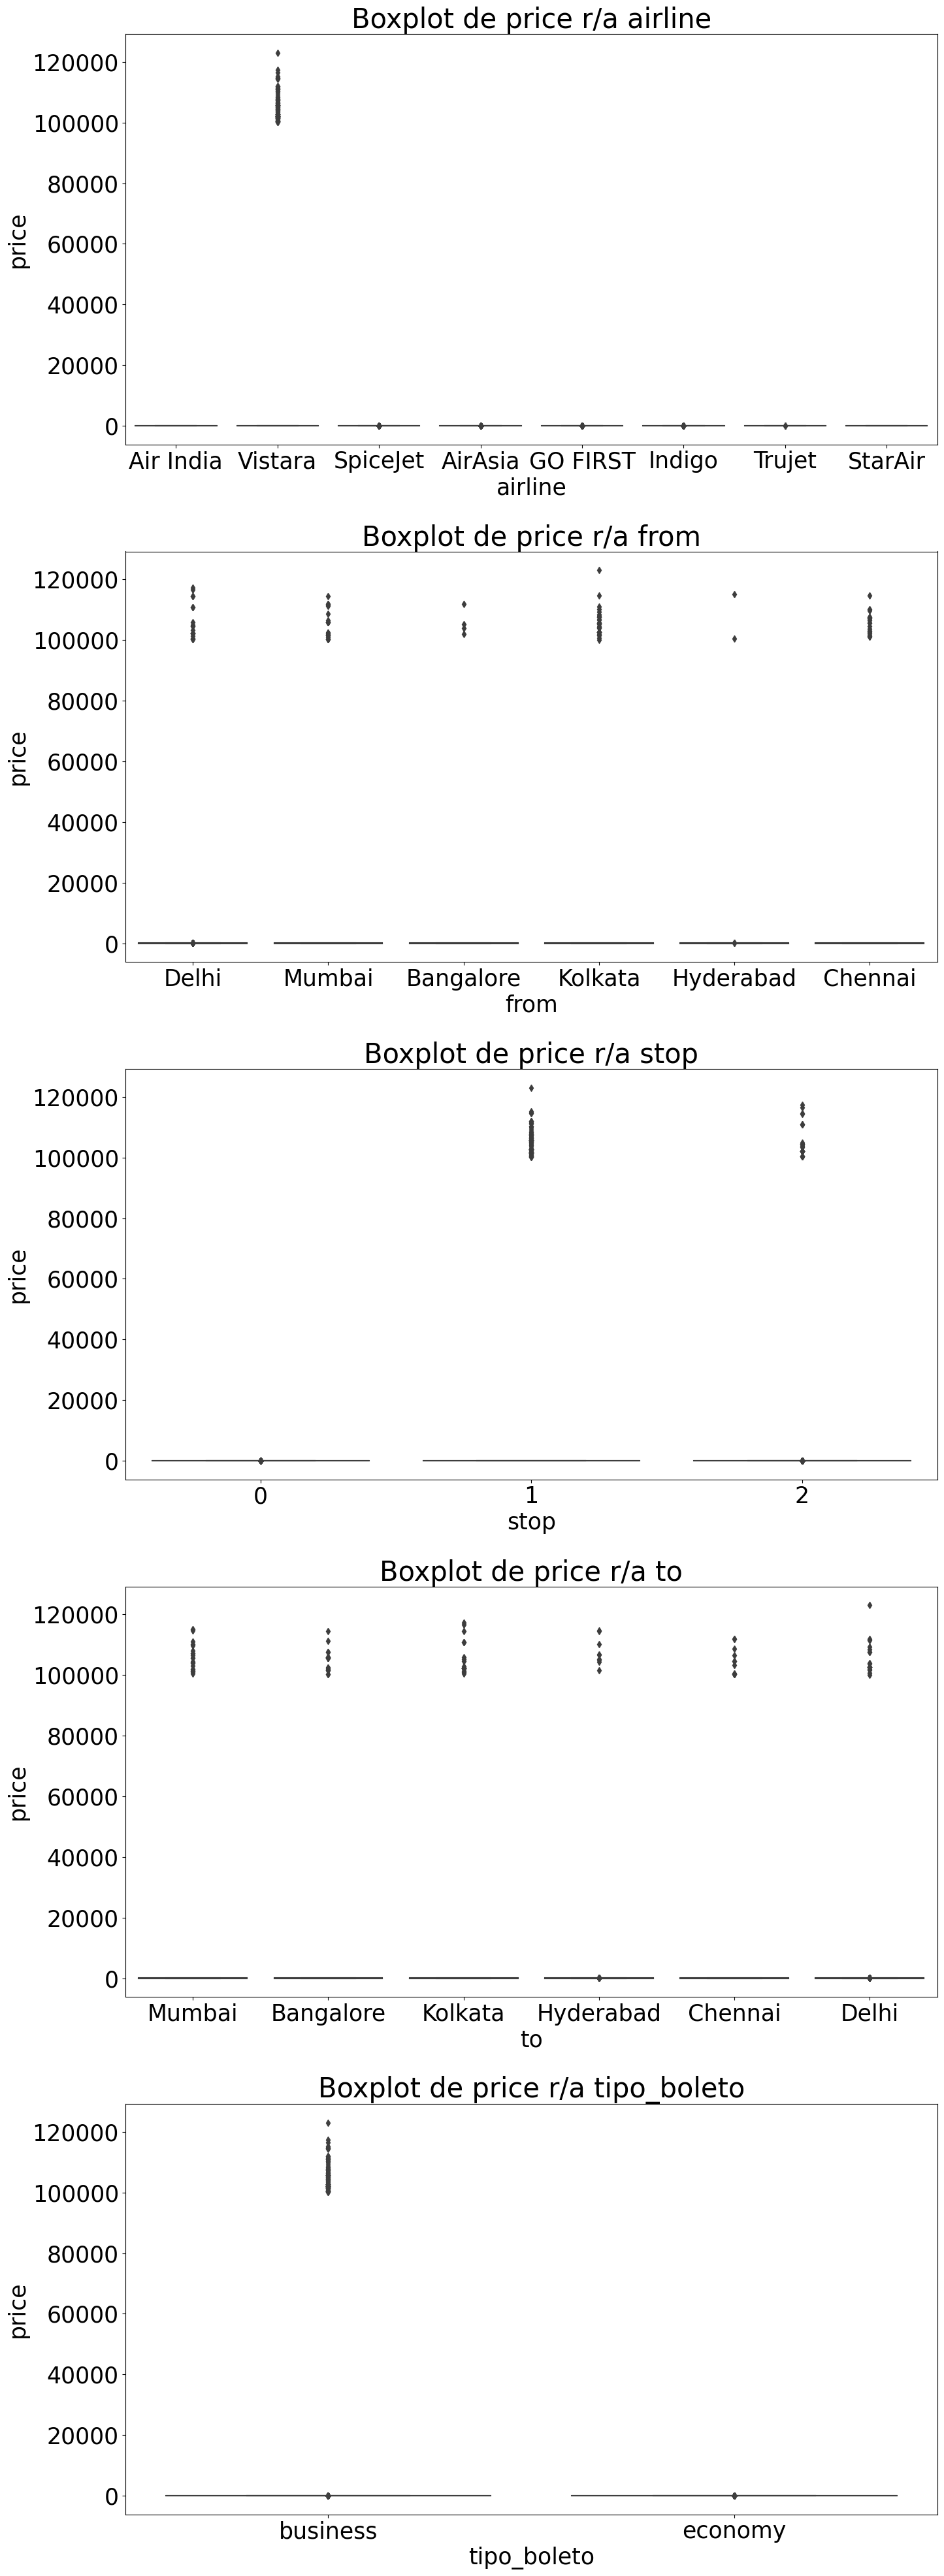

In [ ]:
plot_relation(df, 'price', columns_review=['airline', 'from', 'stop', 'to', 'tipo_boleto'])

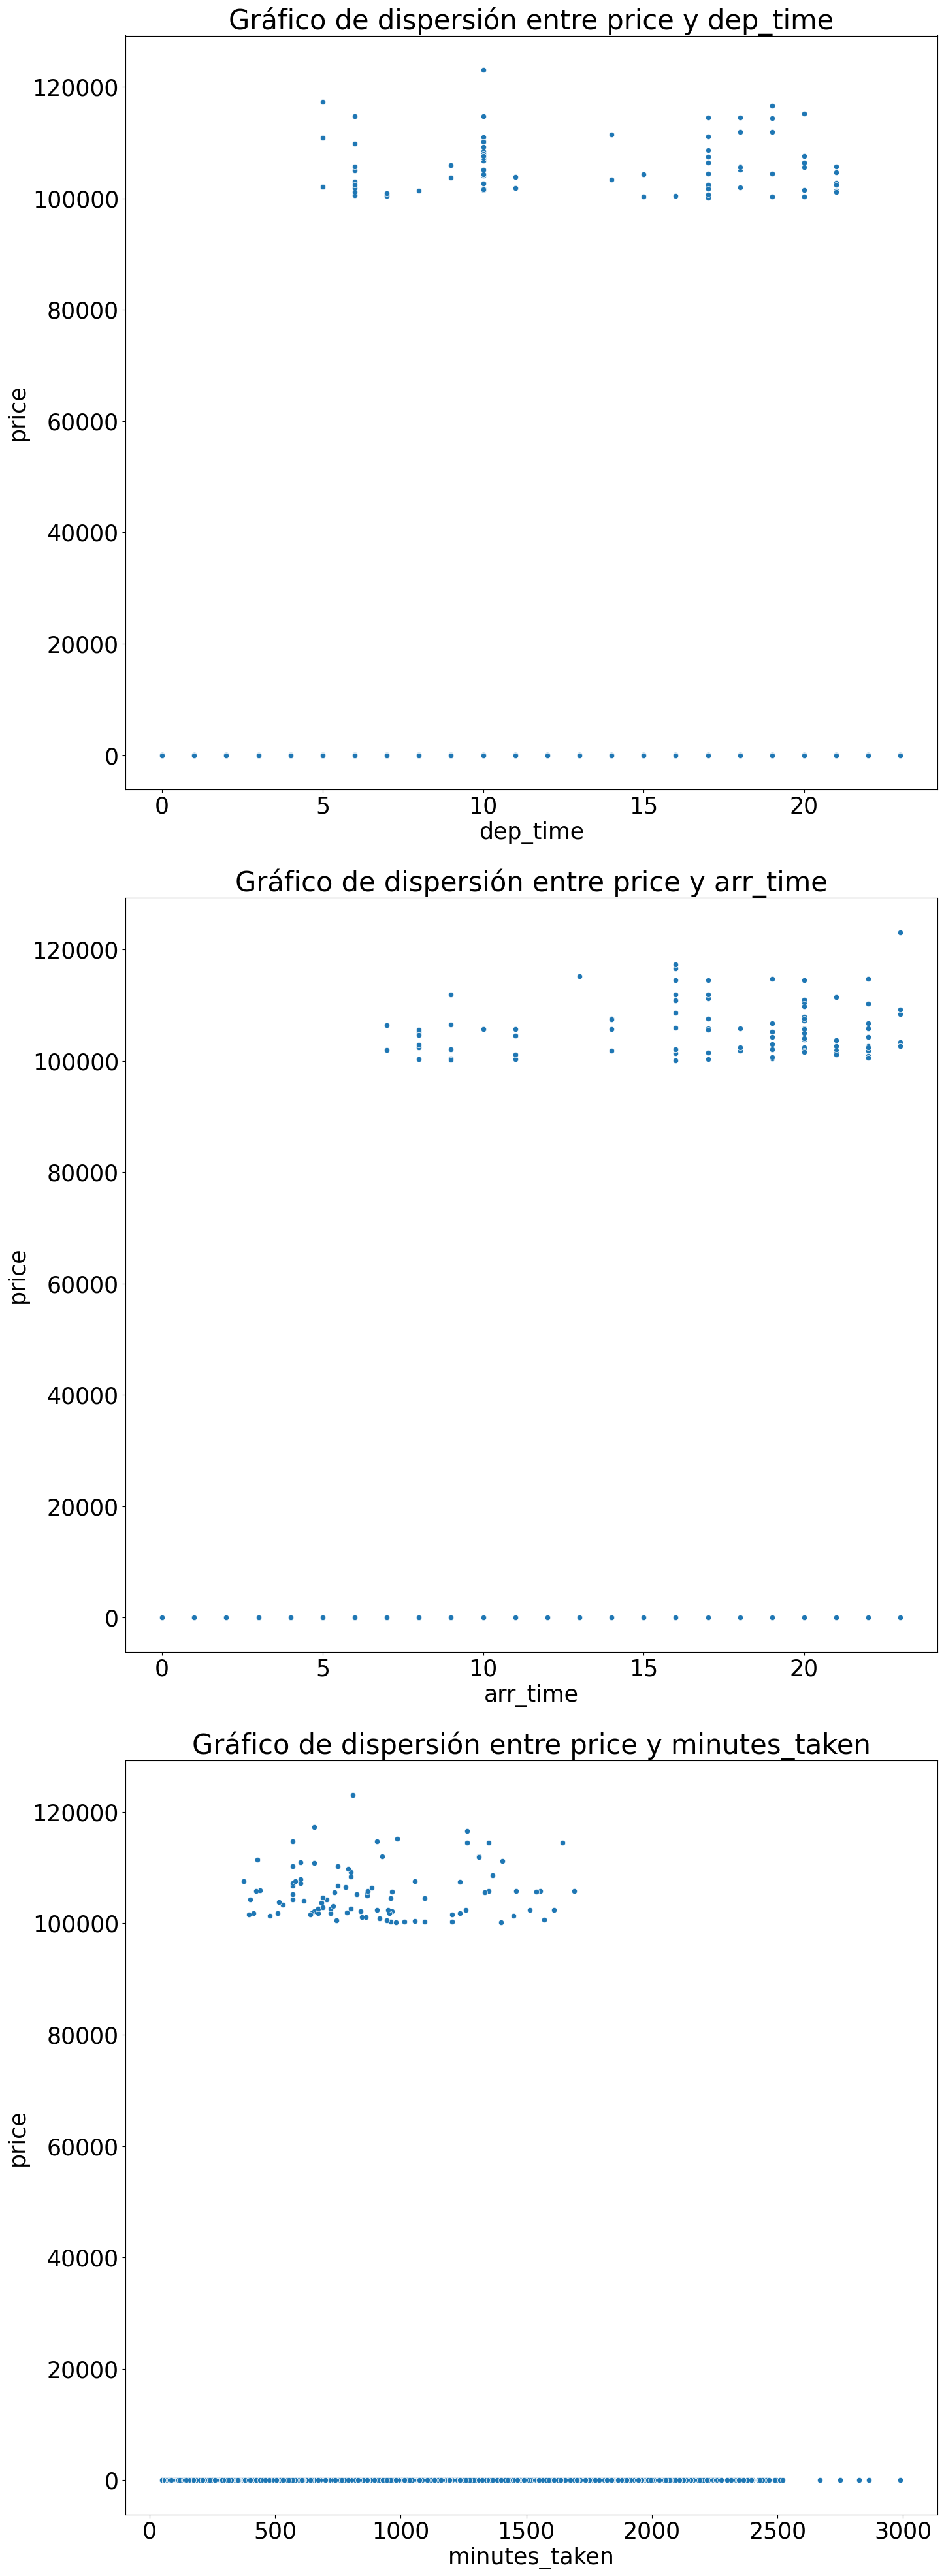

In [ ]:
plot_relation(df, 'price', columns_review=['dep_time', 'arr_time', 'minutes_taken'])

**COMENTARIOS**

- Claramente hay una distribucion muy diferente entre boletos business y boletos economy, se puede pensar en hacer 1 o 2 modelos según estimen conveniente
- Se ve a priori un sesgo en las aerolineas, marcadas posiblemente por aerolineas low cost
- Se observa que no hay gran diferencia entre origen y destino de vuelo
- Se observa una relacion directa respecto al tiempo de vuelo.

### Transformaciones
Se construyen algunas variables extras

In [ ]:
df['dep_period'] = np.where(df['dep_time']<7, 'madrugada', np.where(df['dep_time']<13, 'mañana', 'tarde'))

## 4. Correlaciones

In [ ]:
var_obj = 'price'

var_num = ['dep_time', 'stop', 'arr_time', 'minutes_taken']
var_cat = ['airline', 'from', 'to', 'tipo_boleto', 'dep_period']

In [ ]:
correlation = df.loc[:, [var_obj]+var_num].corr()
correlation

,price,dep_time,arr_time,minutes_taken
price,1.000000,0.000035,0.007007,0.009008
dep_time,0.000035,1.000000,-0.159035,0.142850
arr_time,0.007007,-0.159035,1.000000,-0.022754
minutes_taken,0.009008,0.142850,-0.022754,1.000000


<Axes: >

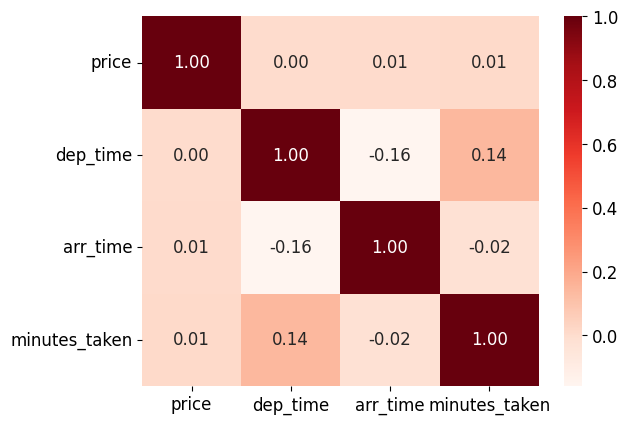

In [ ]:
plt.rcParams.update({'font.size': 12})
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='Reds')

In [ ]:
def anova_test(data, var_obj, var_cat):
    # Agrupar los datos por día
    grouped_data = [data[var_obj][data[var_cat] == sex] for sex in data[var_cat].unique()]

    # Realizar el test de ANOVA
    statistic, p_value = stats.f_oneway(*grouped_data)

    # Imprimir el resultado del test
    alpha = 0.05
    if p_value < alpha:
        print("El test de ANOVA es significativo, al menos un grupo es diferente.")
    else:
        print("No hay evidencia suficiente para rechazar la hipótesis nula.")

    # Graficar los datos con un boxplot
    sns.boxplot(x=var_cat, y=var_obj, data=data)
    plt.title(f'Boxplot {var_obj} vs {var_cat}')
    plt.show()

El test de ANOVA es significativo, al menos un grupo es diferente.


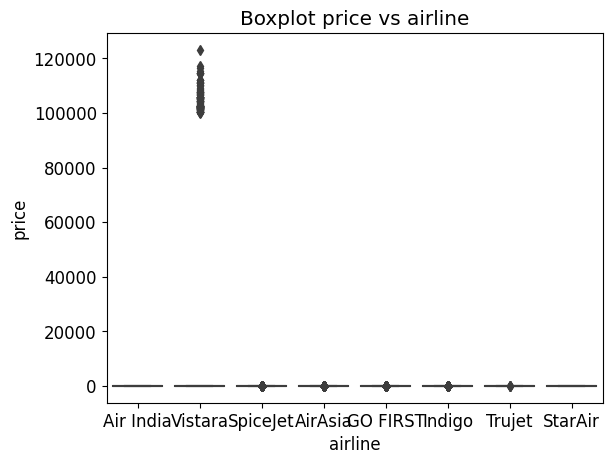

El test de ANOVA es significativo, al menos un grupo es diferente.


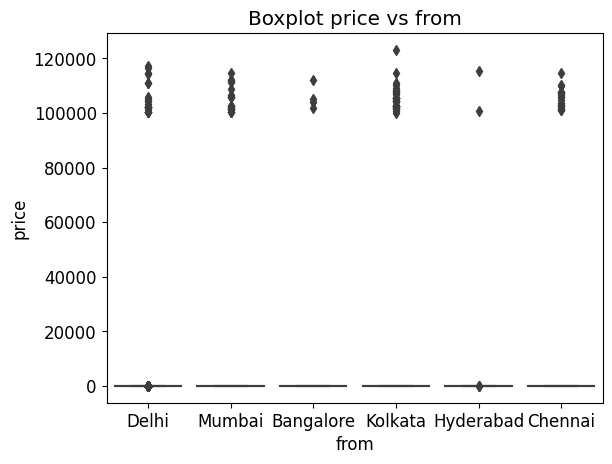

No hay evidencia suficiente para rechazar la hipótesis nula.


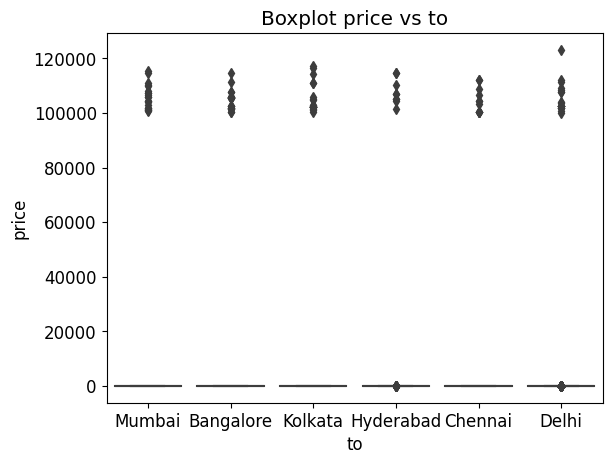

El test de ANOVA es significativo, al menos un grupo es diferente.


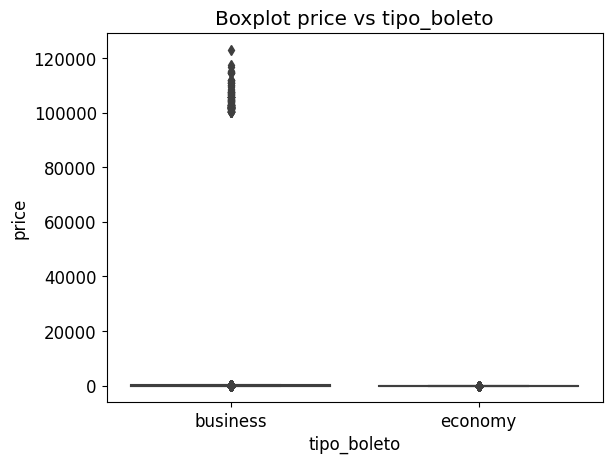

No hay evidencia suficiente para rechazar la hipótesis nula.


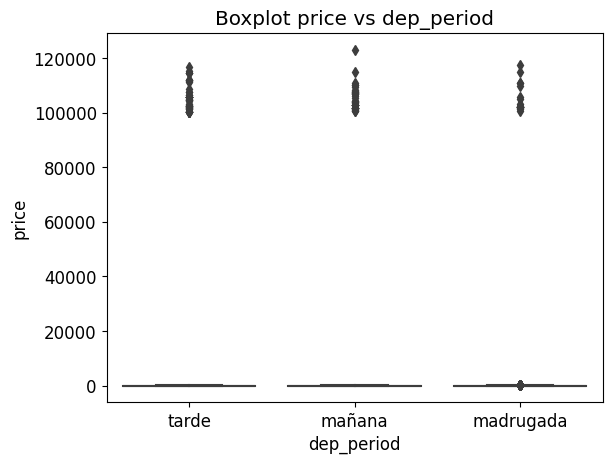

In [ ]:
for vc in var_cat:
    anova_test(df, var_obj, vc)

## 5. Tranformación de variables

In [ ]:
df_final = df.loc[:, ['dep_time', 'stop', 'arr_time', 'minutes_taken', 'airline', 'from', 'to', 'tipo_boleto', 'dep_period', 'price']]
df_final = pd.get_dummies(df_final)

In [ ]:
def seleccion_anova(data, var_obj, var_cat):
    # Agrupar los datos por día
    grouped_data = [data[var_obj][data[var_cat] == var] for var in data[var_cat].unique()]

    # Realizar el test de ANOVA
    statistic, p_value = stats.f_oneway(*grouped_data)

    # Imprimir el resultado del test
    alpha = 0.01
    if p_value < alpha:
        return True
    else:
        return False

cols_probar = ['stop_0', 'stop_1',
       'stop_2', 'airline_Air India', 'airline_AirAsia', 'airline_GO FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_StarAir',
       'airline_Trujet', 'airline_Vistara', 'from_Bangalore', 'from_Chennai',
       'from_Delhi', 'from_Hyderabad', 'from_Kolkata', 'from_Mumbai',
       'to_Bangalore', 'to_Chennai', 'to_Delhi', 'to_Hyderabad', 'to_Kolkata',
       'to_Mumbai', 'tipo_boleto_business', 'tipo_boleto_economy',
       'dep_period_madrugada', 'dep_period_mañana', 'dep_period_tarde']

columns_keep = []
for ci in cols_probar:
    result = seleccion_anova(df_final, var_obj='price', var_cat=ci)
    if result:
        columns_keep.append(ci)

**COMENTARIOS**

- En este punto se puede hacer cualquier transformacion o creacion de variable que se estime conveniente, justificar con gráficos o intuicion, se puede aplicar logaritmos (que es típico en precios). Lo mínimo es crear algunas de las columnas que ya creamos y generar las variables dummies.

## 6. Pipeline Tranformación de datos

In [ ]:
def etl_fligths_prices(df_economy, df_business):
    df_business['tipo_boleto'] = 'business'
    df_economy['tipo_boleto'] = 'economy'

    df = pd.concat([df_business, df_economy]).reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.date
    df['dep_time'] = pd.to_datetime(df['dep_time']).dt.hour
    df['arr_time'] = pd.to_datetime(df['arr_time']).dt.hour
    df['horas'] = pd.to_numeric(df['time_taken'].str.split(' ').str[0].str.replace('h', ''))
    df['mins'] = pd.to_numeric(df['time_taken'].str.split(' ').str[1].str.replace('m', '')).fillna(0)
    df['minutes_taken'] = (df['horas'] * 60 + df['mins']).astype('int')
    df['stop'] = df['stop'].str.extract('(\d)').fillna(0)
    #df['price'] = df['price'].str.replace(',', '').astype('float')
    df['price'] = df['price'].astype('str').str.replace(',', '').astype('float')

    df = df.drop(['ch_code', 'num_code', 'time_taken', 'horas', 'mins'], axis=1)
    df['dep_period'] = np.where(df['dep_time']<7, 'madrugada', np.where(df['dep_time']<13, 'mañana', 'tarde'))

    df_final = df.loc[:, ['dep_time', 'stop', 'arr_time', 'minutes_taken', 'airline', 'from', 'to', 'tipo_boleto', 'dep_period', 'price']]
    df_final = pd.get_dummies(df_final)
    df_final = df_final.drop(['dep_period_tarde'], axis=1)

    return df_final

In [ ]:
df_final = etl_fligths_prices(df_economy, df_business)
df_final.shape

(300261, 31)

In [ ]:
df_final.head()

,dep_time,arr_time,minutes_taken,price,stop_0,stop_1,stop_2,airline_Air India,airline_AirAsia,airline_GO FIRST,...,to_Bangalore,to_Chennai,to_Delhi,to_Hyderabad,to_Kolkata,to_Mumbai,tipo_boleto_business,tipo_boleto_economy,dep_period_madrugada,dep_period_mañana
0,18,20,120,25.612,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,19,21,135,25.612,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2,20,20,1485,42.220,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,21,23,1590,44.450,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4,17,23,400,46.690,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
# Contar los valores NaN en la columna 'mi_columna'
cantidad_nan = df_final['price'].isna().sum()

print(f"Cantidad de valores NaN en 'price': {cantidad_nan}")


Cantidad de valores NaN en 'price': 0


## 7. Modelamiento: Definicion modelamiento, split, modelos, etc

In [ ]:
# Supongamos que ya tienes el DataFrame df_final y has separado las características y la variable objetivo.
X = df_final.drop('price', axis=1)
y = df_final['price']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir una lista de modelos con sus respectivas grillas de hiperparámetros
models = [
    {
        'name': 'LinearRegression',
        'model': LinearRegression(),
        'params': {}
    },
    {
        'name': 'Ridge',
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0]}
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {'alpha': [0.01, 0.1, 1.0, 10.0]}
    },
    {
        'name': 'ElasticNet',
        'model': ElasticNet(),
        'params': {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]}
    },
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
    }
]


## 8. Optimización de hiperparámetros

In [ ]:
# Entrenar los modelos y guardar los mejores
best_models = {}

for model_info in models:
    model = model_info['model']
    model_name = model_info['name']
    param_grid = model_info['params']

    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Guardar el mejor modelo
    best_models[model_name] = grid_search.best_estimator_

    # Imprimir los mejores hiperparámetros
    print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")

Mejores hiperparámetros para LinearRegression: {}
Mejores hiperparámetros para Ridge: {'alpha': 10.0}
Mejores hiperparámetros para Lasso: {'alpha': 1.0}
Mejores hiperparámetros para ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.8}
Mejores hiperparámetros para RandomForestRegressor: {'max_depth': 10, 'n_estimators': 200}


## 9. Persistencia de modelos

In [ ]:
for model_name, model in best_models.items():
    joblib.dump(model, f"{model_name}_model.pkl")

## 10. Evaluación

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# Supongamos que tienes una lista de los nombres de los modelos y los archivos .pkl
model_names = ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "RandomForestRegressor"]
model_files = ["LinearRegression_model.pkl", "Ridge_model.pkl", "Lasso_model.pkl", "ElasticNet_model.pkl", "RandomForestRegressor_model.pkl"]


In [ ]:
# Crear DataFrames para almacenar resultados
results = []

# Calcular métricas para cada modelo y almacenar los resultados
for model_name, model_file in zip(model_names, model_files):
    model = joblib.load(model_file)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    ape = np.abs((y_test - y_pred) / y_test)
    mape = np.mean(ape) * 100

    results.append(pd.DataFrame({"Model": [model_name], "R^2": [r2], "MAE": [mae], "MAPE": [mape]}))

results = pd.concat(results).reset_index(drop=True)
# Mostrar resultados
print("Resultados de evaluación de modelos:")
print(results)

Resultados de evaluación de modelos:
                   Model       R^2         MAE        MAPE
0       LinearRegression  0.001733  104.662995  747.009813
1                  Ridge  0.001733  104.636957  746.541586
2                  Lasso  0.001948   97.927280  623.181061
3             ElasticNet  0.001918   97.057580  624.746034
4  RandomForestRegressor  0.020155   64.126809   78.901315


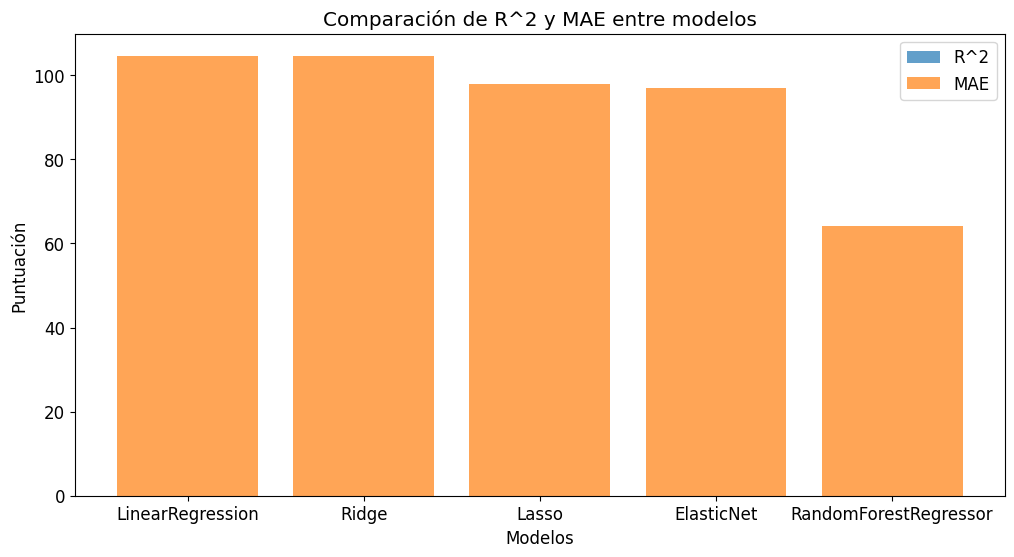

In [ ]:
# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.bar(results["Model"], results["R^2"], label="R^2", alpha=0.7)
plt.bar(results["Model"], results["MAE"], label="MAE", alpha=0.7)
plt.xlabel("Modelos")
plt.ylabel("Puntuación")
plt.title("Comparación de R^2 y MAE entre modelos")
plt.legend()
plt.show()